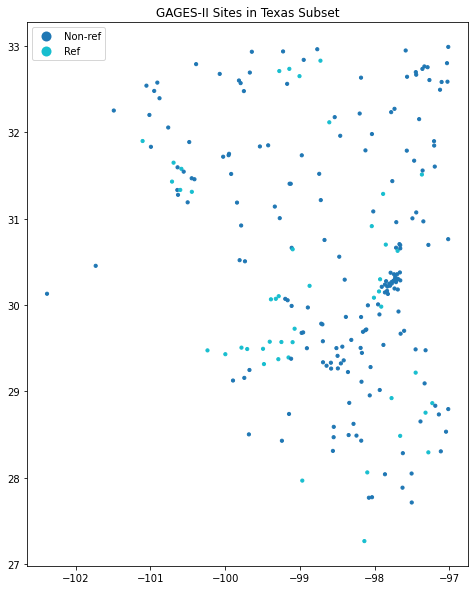

In [237]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

gages = gpd.read_file('/Projects/HydroMet/currierw/gagesII/gagesII_9322_sept30_2011.shp')
# Load Excel table with full attributes
# Load only the relevant sheet and columns
dams = pd.read_excel(
    "/Projects/HydroMet/currierw/gagesII/gagesII_sept30_2011_conterm.xlsx",
    sheet_name="HydroMod_Dams",
    usecols=["STAID", "NDAMS_2009"],
    dtype={"STAID": str}
)
# Merge the Excel data with the shapefile
gages = gages.merge(dams, on="STAID", how="left").to_crs(epsg=4326)

# Subset to Texas
gages_tx = gages[gages["STATE"] == "TX"]

minlon = -103
maxlon = -97
minlat  = 27
maxlat = 33

# Build texas subset
gages_tx = gages_tx.cx[minlon:maxlon, minlat:maxlat]

fig, ax = plt.subplots(figsize=(8, 10))
gages_tx_subset.plot(ax=ax, column="CLASS", legend=True, markersize=10)
ax.set_title("GAGES-II Sites in Texas Subset")
plt.show()

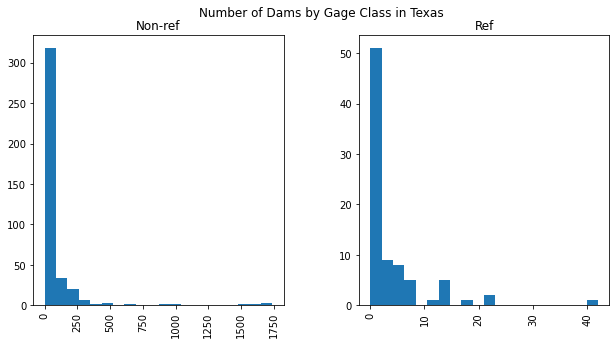

In [127]:
gages_tx["NDAMS_2009"].hist(by=gages_tx["CLASS"], bins=20, figsize=(10, 5), layout=(1, 2))
plt.suptitle("Number of Dams by Gage Class in Texas Subset")
plt.show()



In [128]:
ref = gages_tx[gages_tx["CLASS"] == "Ref"]
nonref = gages_tx[gages_tx["CLASS"] != "Ref"]

print("Mean number of upstream dams:")
print("Reference:", ref["NDAMS_2009"].mean())
print("Non-reference:", nonref["NDAMS_2009"].mean())

Mean number of upstream dams:
Reference: 3.9879518072289155
Non-reference: 79.69974554707379


In [129]:
gages_tx["STANAME"] = gages_tx["STANAME"].fillna("").astype(str)

# Case-insensitive search for "Lampasas"
lampasas_matches = gages_tx[gages_tx["STANAME"].str.contains("lampasas", case=False)]

# Case-insensitive search for "Guadalupe"
guadalupe_matches = gages_tx[gages_tx["STANAME"].str.contains("guadalupe", case=False)]

# Show Lampasas gages and their reference class
print("Lampasas matches:")
print(lampasas_matches[["STAID", "STANAME", "CLASS", "NDAMS_2009"]])

# Show Guadalupe gages
print("\nGuadalupe matches:")
print(guadalupe_matches[["STAID", "STANAME", "CLASS", "NDAMS_2009"]])

Lampasas matches:
         STAID                        STANAME    CLASS  NDAMS_2009
6233  08103800     Lampasas Rv nr Kempner, TX  Non-ref        33.0
6235  08104000  Lampasas Rv at Youngsport, TX  Non-ref        34.0
6236  08104100      Lampasas Rv nr Belton, TX  Non-ref        35.0

Guadalupe matches:
         STAID                                         STANAME    CLASS  \
6345  08165300                   N Fk Guadalupe Rv nr Hunt, TX      Ref   
6346  08165500                        Guadalupe Rv at Hunt, TX      Ref   
6348  08166140       Guadalupe Rv abv Bear Ck at Kerrville, TX  Non-ref   
6349  08166200                   Guadalupe Rv at Kerrville, TX  Non-ref   
6350  08166250                Guadalupe Rv nr Center Point, TX  Non-ref   
6351  08167000                     Guadalupe Rv at Comfort, TX  Non-ref   
6352  08167500               Guadalupe Rv nr Spring Branch, TX  Non-ref   
6353  08167800                     Guadalupe Rv at Sattler, TX  Non-ref   
6354  08168500  Gua

/home/wcurrier/.conda/envs/py3/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [238]:
import pandas as pd
import requests
from io import StringIO

# Extract and retain four separate daily time series, where available:

# Discharge max (00060_00001)
# Discharge mean (00060_00003)
# Gage height max (00065_00001)
# Gage height mean (00065_00003)

# For each, compute annual max values, including special July-only logic for 2025.

# If any max-type (00001) records are available (e.g., gage height max), we:

# Download the peak flow archive

# Compare and optionally combine with the corresponding 00001 record.

# Output: a dictionary of all daily series (annual_daily) + peak + combined versions for merging or inspection.

# Let user decide later what to use.

import pandas as pd
import requests
from io import StringIO

def get_all_gage_and_discharge_records(site_no, verbose=False):
    try:
        def fetch_daily_timeseries(site_no, param, stat):
            url = (
                f"https://waterdata.usgs.gov/nwis/dv?cb_{param}=on&format=rdb"
                f"&site_no={site_no}&begin_date=1900-01-01&end_date=2025-12-31"
            )
            response = requests.get(url, timeout=30)
            lines = [l for l in response.text.splitlines() if not l.startswith("#")]
            if not lines:
                return None
            df = pd.read_csv(StringIO("\n".join(lines)), sep="\t", dtype=str)

            # Handle missing agency_cd
            if 'agency_cd' in df.columns:
                df = df[~df['agency_cd'].str.contains(r'^\d+s$', na=False)]

            if 'datetime' not in df.columns:
                return None
            df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

            col = [c for c in df.columns if param in c and stat in c]
            if not col:
                return None

            df = df[['datetime', col[0]]].copy()
            df.columns = ['datetime', 'value']
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df = df.set_index('datetime')
            return df

        def compute_annual_max(df, param_label):
            if df is None or df.empty:
                return None
            df = df.copy()
            max_july = None
            if 2025 in df.index.year:
                july_vals = df.loc[(df.index.year == 2025) & (df.index.month == 7), 'value']
                max_july = july_vals.max(skipna=True)
                df = df[df.index.year != 2025]
            annual = df['value'].resample('Y').agg(lambda x: x.max(skipna=True)).to_frame(name=param_label)
            annual['year'] = annual.index.year
            annual['source'] = param_label
            if max_july is not None:
                annual.loc[pd.Timestamp('2025-12-31')] = [max_july, 2025, param_label]
            return annual.set_index('year')

        def fetch_peak_data(site_no):
            url = f"https://nwis.waterdata.usgs.gov/nwis/peak?site_no={site_no}&agency_cd=USGS&format=rdb"
            text = requests.get(url, timeout=30).text
            lines = [l for l in text.splitlines() if not l.startswith("#")]
            if not lines:
                return None
            df = pd.read_csv(StringIO("\n".join(lines)), sep="\t", dtype=str)
            if 'agency_cd' in df.columns:
                df = df[~df['agency_cd'].str.contains(r'^\d+s$', na=False)]

            if 'peak_dt' not in df.columns or 'gage_ht' not in df.columns:
                return None
            df['peak_dt'] = pd.to_datetime(df['peak_dt'], errors='coerce')
            df['gage_ht'] = pd.to_numeric(df['gage_ht'], errors='coerce')
            df['year'] = df['peak_dt'].dt.year
            peak_gh = df.groupby('year')['gage_ht'].max().to_frame(name='gage_height_ft')
            peak_gh['source'] = 'peak'
            return peak_gh

        # Fetch daily data
        daily_raw = {}
        annual_daily = {}
        for param, stat, label in [
            ('00065', '00001', 'gage_height_ft_max'),
            ('00065', '00003', 'gage_height_ft_mean'),
            ('00060', '00001', 'discharge_cfs_max'),
            ('00060', '00003', 'discharge_cfs_mean'),
        ]:
            df = fetch_daily_timeseries(site_no, param, stat)
            if df is not None:
                daily_raw[label] = df
                annual_df = compute_annual_max(df, label)
                if annual_df is not None:
                    annual_daily[label] = annual_df
                    if verbose:
                        print(f"{site_no}: Found {label} with {len(annual_df)} years")

        # Fetch peak archive
        peak_df = fetch_peak_data(site_no)
        if verbose and peak_df is not None:
            print(f"{site_no}: Found peak gage height with {len(peak_df)} years")

        # Combine daily max gage height with peak (if available)
        merged = {}
        if 'gage_height_ft_max' in annual_daily and peak_df is not None:
            daily_gh_max = annual_daily['gage_height_ft_max']
            merged_gh = peak_df.combine_first(daily_gh_max)
            merged_gh.update(daily_gh_max)
            merged_gh = merged_gh.sort_index()
            merged['gage_height_ft_max_combined'] = merged_gh

            # Verify agreement
            verify = pd.merge(
                daily_gh_max[['gage_height_ft_max']],
                peak_df[['gage_height_ft']],
                left_index=True,
                right_index=True,
                how='inner',
                suffixes=('_daily', '_peak')
            )
            verify['diff'] = verify['gage_height_ft_max'] - verify['gage_height_ft']
            verify['match'] = verify['diff'].abs() < 0.1
            mismatches = (~verify['match']).sum()
            if mismatches > 0:
                print(f"⚠️  {site_no}: {mismatches} mismatches between peak and daily gage height")

        return {
            'daily_raw': daily_raw,
            'annual_daily': annual_daily,
            'peak': peak_df,
            'merged': merged,
        }

    except Exception as e:
        print(f"⚠️  Error processing site {site_no}: {e}")
        return None

# The returned dictionary has:

# 'daily_raw': raw daily time series (datetime index)
# 'annual_daily': annual max dataframes by type
# 'peak': peak gage height archive (if available)
# 'merged': combined version of daily max and peak (if gage height max is available)



In [239]:
#  Goal is to determine, for each gage, which of the four daily-derived annual records
# (gage_height_ft_max, gage_height_ft_mean, discharge_cfs_max, discharge_cfs_mean) contains
# the longest sequence of non-NaN years, and save that info for later use.

def summarize_best_record(site_no, annual_dict):
    summary = []
    for varname, df in annual_dict.items():
        non_nan = df[varname].dropna()
        if not non_nan.empty:
            years = non_nan.index
            summary.append({
                "site_no": site_no,
                "varname": varname,
                "n_years": len(non_nan),
                "start_year": years.min(),
                "end_year": years.max()
            })

    if not summary:
        return pd.DataFrame([{"site_no": site_no, "varname": None, "n_years": 0, "start_year": None, "end_year": None}])
    
    # Find the longest one
    df_summary = pd.DataFrame(summary)
    df_summary = df_summary.sort_values("n_years", ascending=False).reset_index(drop=True)
    df_summary = df_summary.rename(columns={'varname': 'longest_type'})
    return df_summary.head(1)

In [240]:
gage_ids = gages_tx["STAID"].tolist()
len(gage_ids)

232

In [241]:
# gage_ids = gages_tx[gages_tx["CLASS"] == "Ref"]["STAID"].tolist()

import os
import pandas as pd

output_dir = "/Projects/HydroMet/currierw/USGS_Texas_gage_data/"
os.makedirs(output_dir, exist_ok=True)

# --- Remove existing .pkl files in output_dir ---
# for f in os.listdir(output_dir):
#     if f.endswith(".pkl"):
#         os.remove(os.path.join(output_dir, f))

# --- Initialize summary list ---
all_summaries = []

# --- Get gage list ---
gage_ids = gages_tx["STAID"].tolist()

# --- Loop with status updates ---
for i, site_no in enumerate(gage_ids, 1):
    print(f"Processing {i}/{len(gage_ids)}: {site_no}")
    try:
        result = get_all_gage_and_discharge_records(site_no, verbose=False)
        if result is None:
            continue

        # Save full data to disk
        out_path = os.path.join(output_dir, f"{site_no}.pkl")
        pd.to_pickle(result, out_path)

        # Create summary
        best = summarize_best_record(site_no, result['annual_daily'])
        if best is not None:
            all_summaries.append(best)

    except Exception as e:
        print(f"⚠️ Failed processing {site_no}: {e}")
        continue

# --- Combine all summaries into DataFrame ---
summary_df = pd.concat(all_summaries, ignore_index=True)
summary_df.to_csv("longest_clean_record_summary.csv", index=False)


Processing 1/232: 08044800
⚠️  08044800: 2 mismatches between peak and daily gage height
Processing 2/232: 08046000
Processing 3/232: 08047000
Processing 4/232: 08047050
⚠️  08047050: 2 mismatches between peak and daily gage height
Processing 5/232: 08047500
⚠️  08047500: 9 mismatches between peak and daily gage height
Processing 6/232: 08048000
⚠️  08048000: 15 mismatches between peak and daily gage height
Processing 7/232: 08048543
⚠️  08048543: 15 mismatches between peak and daily gage height
Processing 8/232: 08048970
⚠️  08048970: 13 mismatches between peak and daily gage height
Processing 9/232: 08049500
⚠️  08049500: 10 mismatches between peak and daily gage height
Processing 10/232: 08049580
Processing 11/232: 08049600
Processing 12/232: 08049700
⚠️  08049700: 11 mismatches between peak and daily gage height
Processing 13/232: 08055000
⚠️  08055000: 2 mismatches between peak and daily gage height
Processing 14/232: 08083100
Processing 15/232: 08083230
Processing 16/232: 0808324

In [242]:
import pandas as pd
import os

rank_records = []

for _, row in summary_df.iterrows():
    site_no = str(row['site_no'])
    series_name = row['longest_type'] # look for the parameter (daily mean/max discharge/gauge height) with the longest record and use that one
    n_years = row['n_years']

    try:
        # Load the pickled result
        result = pd.read_pickle(os.path.join(output_dir, f"{site_no}.pkl"))
        annual_df = result['annual_daily'].get(series_name, None)
        if annual_df is None or 2025 not in annual_df.index:
            continue

        values = annual_df[series_name].dropna()
        val_2025 = values.get(2025, None)
        if pd.isna(val_2025):
            continue

        # Rank 2025 (1 = highest)
        rank = values.rank(ascending=False, method="min").get(2025)

        rank_records.append({
            "site_no": site_no,
            "series_name": series_name,
            "n_years": len(values),
            "value_2025": val_2025,
            "rank_2025": int(rank),
        })

    except Exception as e:
        print(f"⚠️ Skipping {site_no}: {e}")
        continue

rank_df = pd.DataFrame(rank_records)
# rank_df.to_csv("gage_2025_rankings.csv", index=False)
rank_df

,site_no,series_name,n_years,value_2025,rank_2025
0,08044800,gage_height_ft_max,31,3.17,31
1,08047000,discharge_cfs_mean,79,170.00,63
2,08047050,gage_height_ft_max,28,8.26,15
3,08047500,discharge_cfs_mean,102,697.00,93
4,08048000,discharge_cfs_mean,106,740.00,102
...,...,...,...,...,...
176,08211520,discharge_cfs_mean,54,9.40,54
177,08211800,discharge_cfs_mean,27,0.00,25
178,08211900,discharge_cfs_mean,50,2.06,50
179,08212400,discharge_cfs_mean,44,0.00,40


In [244]:
print(rank_df['rank_2025'].min())
print(rank_df['rank_2025'].max())

1
117


In [246]:
print(rank_df['n_years'].min())
print(rank_df['n_years'].max())

15
119


In [254]:
gdf_ranked = gdf_ranked.sort_values(by="rank_2025", ascending=False)

In [285]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Updated city list with coordinates
cities_data = {
    "city": [
        "Houston", "San Antonio", "Dallas", "Austin", "El Paso", "Corpus Christi", "Lubbock",
        "San Angelo", "Kerrville", "Lampasas"
    ],
    "lat": [
        29.7604, 29.4241, 32.7767, 30.2672, 31.7619, 27.8006, 33.5779,
        31.4638, 30.0474, 31.0635
    ],
    "lon": [
        -95.3698, -98.4936, -96.7970, -97.7431, -106.4850, -97.3964, -101.8552,
        -100.4370, -99.1400, -98.1830
    ]
}


# Create GeoDataFrame
cities_df = pd.DataFrame(cities_data)
cities_gdf = gpd.GeoDataFrame(
    cities_df,
    geometry=[Point(xy) for xy in zip(cities_df.lon, cities_df.lat)],
    crs="EPSG:4326"
)

# Optional: Load US counties (from public carto source)
counties = gpd.read_file("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json").to_crs("EPSG:4326")
counties_tx = counties[counties["STATE"] == "48"].to_crs("EPSG:4326")


# Download from US Census TIGER/Line: States
states_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_500k.zip"
states = gpd.read_file(states_url)

# Filter for Texas (FIPS code 48 or name)
texas = states[states['NAME'] == 'Texas'].to_crs("EPSG:4326")

rivers_tx = gpd.read_file("medium_sized_rivers.gpkg", layer="rivers")


/home/wcurrier/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:161: UserWarning: Use the colorbar set_ticks() method instead.
/home/wcurrier/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:183: UserWarning: Use the colorbar set_ticks() method instead.


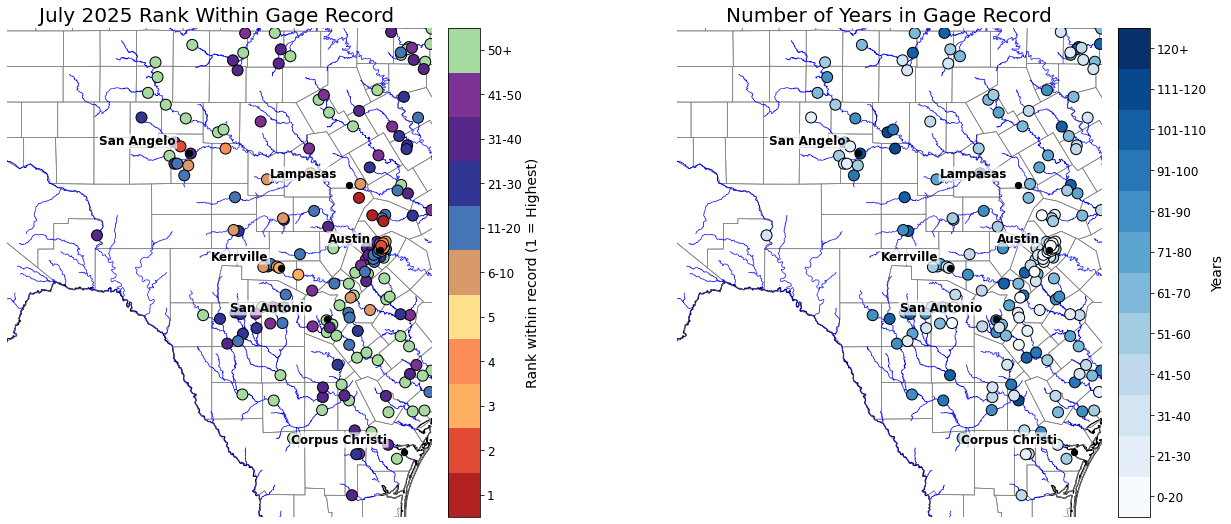

In [293]:

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colorbar import ColorbarBase
import pandas as pd
from matplotlib.cm import get_cmap


# --- User-defined zoom box ---
minx, maxx = -103, -97
miny, maxy = 27.0, 33



# --- Filter cities inside zoom box ---
cities_in_box = cities_gdf.cx[minx:maxx, miny:maxy]

# --- Prepare discrete bins & labels for rank_2025 ---
rank_bins = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, np.inf]
rank_labels = ['1', '2', '3', '4', '5', '6-10', '11-20', '21-30', '31-40', '41-50', '50+']
gdf_ranked['rank_bins'] = pd.cut(
    gdf_ranked['rank_2025'], bins=rank_bins, labels=rank_labels, right=True, include_lowest=True)
gdf_ranked['rank_code'] = gdf_ranked['rank_bins'].cat.codes

# --- Prepare discrete bins & labels for n_years ---
years_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, np.inf]
years_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80',
                '81-90', '91-100', '101-110', '111-120', '120+']
gdf_ranked['years_bins'] = pd.cut(
    gdf_ranked['n_years'], bins=years_bins, labels=years_labels, right=True, include_lowest=True)
gdf_ranked['years_code'] = gdf_ranked['years_bins'].cat.codes
gdf_ranked = gdf_ranked[(gdf_ranked['rank_code'] >= 0) & (gdf_ranked['years_code'] >= 0)]


# --- Drop missing codes ---
gdf_ranked = gdf_ranked[(gdf_ranked['rank_code'] >= 0) & (gdf_ranked['years_code'] >= 0)]
# --- Define colormaps and norms ---
rank_colors = [
    '#b22222',  # 1 - Firebrick (deep red, more distinct)
    '#e34a33',  # 2 - Strong orange-red
    '#fdae61',  # 3 - Darker orange
    '#fc8d59',  # 4 - Orange
    '#fee08b',  # 5 - Yellow
    '#d9996b',  # 6-10 - Muted warm brown/terra cotta (less distinctive than pink)

    '#4575b4',  # 11-20 - Blue
    '#313695',  # 21-30 - Dark blue
    '#542788',  # 31-40 - Purple
    '#7b3294',  # 41-50 - Lighter purple
    '#a6dba0'   # 50+ - Muted greenish for distinct cool color
]

rank_cmap = ListedColormap(rank_colors)
rank_norm = BoundaryNorm(np.arange(-0.5, len(rank_labels)+0.5, 1), rank_cmap.N)

# Create a ListedColormap with N discrete colors from "Blues"
N = len(years_labels)
years_cmap = ListedColormap(get_cmap("Blues", N)(np.arange(N)))
# years_cmap = ListedColormap(years_colors)
years_norm = BoundaryNorm(np.arange(-0.5, len(years_labels) + 0.5, 1), years_cmap.N)

gdf_ranked['rank_code'] = gdf_ranked['rank_code'].astype(int)
gdf_ranked['years_code'] = gdf_ranked['years_code'].astype(int)

# --- Create figure and axes ---
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# --- Plot 1: Rank 2025 ---
gdf_ranked.plot(
    column='rank_code',
    cmap=rank_cmap,
    norm=rank_norm,
    legend=False,
    ax=axes[0],
    edgecolor='k',
    markersize=120,
    zorder=4
)
texas.boundary.plot(ax=axes[0], color='black', linewidth=1.2, zorder=1)
counties_tx.boundary.plot(ax=axes[0], color='gray', linewidth=0.7, zorder=2)
rivers_tx.plot(ax=axes[0], color='blue', linewidth=0.7, zorder=3)
cities_in_box.plot(ax=axes[0], color='black', markersize=40, label='Major Cities', zorder=5)

axes[0].set_title("July 2025 Rank Within Gage Record ", fontsize=20)
axes[0].axis('off')
axes[0].set_xlim(minx, maxx)
axes[0].set_ylim(miny, maxy)

# --- Plot 2: Number of Years ---
gdf_ranked.plot(
    column='years_code',
    cmap=years_cmap,
    norm=years_norm,
    legend=False,
    ax=axes[1],
    edgecolor='k',
    markersize=120,
    zorder=4
)
texas.boundary.plot(ax=axes[1], color='black', linewidth=1.2, zorder=1)
counties_tx.boundary.plot(ax=axes[1], color='gray', linewidth=0.7, zorder=2)
rivers_tx.plot(ax=axes[1], color='blue', linewidth=0.7, zorder=3)
cities_in_box.plot(ax=axes[1], color='black', markersize=40, zorder=5)

axes[1].set_title("Number of Years in Gage Record", fontsize=20)
axes[1].axis('off')
axes[1].set_xlim(minx, maxx)
axes[1].set_ylim(miny, maxy)

# --- Add city labels to the left with dynamic offset ---
for _, row in cities_in_box.iterrows():
    for ax in axes:
        # Calculate offset based on city name length (tweak multiplier if needed)
        name_length = len(row.city)
        x_offset = -3 - (name_length * 1)  # adjust multiplier to fine-tune spacing

        offset = offset_copy(ax.transData, fig=fig, x=x_offset, y=5, units='points')

        ax.text(
            row.geometry.x,
            row.geometry.y,
            row.city,
            fontsize=12,
            fontweight='bold',
            color='black',
            transform=offset,
            ha='right',  # text aligns to the right (so it's left of point)
            va='bottom',
            bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7),
            clip_on=True,
            zorder=10
        )
# --- Add colorbars aligned with plots ---

# Get axes positions
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()

cbar_width = 0.02
cbar_pad = 0.01  # gap between plot and colorbar

# Colorbar for rank_2025
cbar_ax_rank = fig.add_axes([
    pos0.x1 + cbar_pad,
    pos0.y0,
    cbar_width,
    pos0.height
])
cb_rank = ColorbarBase(
    cbar_ax_rank,
    cmap=rank_cmap,
    norm=rank_norm,
    boundaries=np.arange(-0.5, len(rank_labels)+0.5, 1),
    ticks=np.arange(len(rank_labels)),
    spacing='uniform',
    orientation='vertical',
    ticklocation='auto'
)
cbar_ax_rank.set_yticks(np.arange(len(rank_labels)))
cbar_ax_rank.set_yticklabels(rank_labels)
cbar_ax_rank.set_ylabel('Rank within record (1 = Highest)', fontsize=14)
cbar_ax_rank.tick_params(labelsize=12)

# Colorbar for n_years
cbar_ax_years = fig.add_axes([
    pos1.x1 + cbar_pad,
    pos1.y0,
    cbar_width,
    pos1.height
])
cb_years = ColorbarBase(
    cbar_ax_years,
    cmap=years_cmap,
    norm=years_norm,
    boundaries=np.arange(-0.5, len(years_labels)+0.5, 1),
    ticks=np.arange(len(years_labels)),
    spacing='uniform',
    orientation='vertical',
    ticklocation='auto'
)
cbar_ax_years.set_yticks(np.arange(len(years_labels)))
cbar_ax_years.set_yticklabels(years_labels)
cbar_ax_years.set_ylabel('Years', fontsize=14)
cbar_ax_years.tick_params(labelsize=12)

# fig.patch.set_facecolor('white')

# --- Adjust layout ---
# plt.subplots_adjust(left=0.03, right=0.92, top=0.93, bottom=0.05, wspace=0.15)


In [296]:
gdf_ranked_w_dams = gdf_ranked.merge(
    gages_tx[['STAID', 'NDAMS_2009']],
    left_on='site_no',
    right_on='STAID',
    how='left'
)

# Select and display the last 10 rows with dam count
columns_to_display = ['STANAME','site_no', 'rank_2025','DRAIN_SQKM', 'n_years', 'series_name', 'CLASS', 'value_2025', 'NDAMS_2009']

# Filter and pretty print
last_10 = gdf_ranked_w_dams[columns_to_display].tail(23)

# Display
print(last_10.to_string(index=False))

                                           STANAME     site_no  rank_2025   DRAIN_SQKM  n_years          series_name    CLASS  value_2025  NDAMS_2009
                        Pecan Ck nr San Angelo, TX    08131400         10    209.61540       51   discharge_cfs_mean      Ref      474.00         0.0
                Walnut Ck at Dessau Rd, Austin, TX    08158200         10     68.58720       21   discharge_cfs_mean  Non-ref      669.00         5.0
                        Lampasas Rv nr Kempner, TX    08103800         10   2114.55800       64   discharge_cfs_mean  Non-ref    16600.00        33.0
             Guadalupe Rv at FM 1117 nr Seguin, TX    08169792          9   4873.88400       21   gage_height_ft_max  Non-ref       23.85        48.0
                       San Saba Rv at San Saba, TX    08146000          9   7891.80700      108   discharge_cfs_mean  Non-ref    25200.00        72.0
                        N Llano Rv nr Junction, TX    08148500          9   2336.84800       88   di